<a href="https://colab.research.google.com/github/hyunicecream/Natural-Language-Processing-NLP-/blob/main/7_23_news_LSTM_sentence_piece.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
%pip install sentencepiece

     |████████████████████████████████| 1.2 MB 5.3 MB/s 


In [19]:
# Commented out IPython magic to ensure Python compatibility.
import numpy as np
import re
import pickle
from sklearn.datasets import fetch_20newsgroups
import sentencepiece as spm
from tensorflow.keras.layers import Input, Embedding, Dense, LSTM, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns


# %cd '/content/drive/MyDrive/Colab Notebooks'

# news data를 읽어온다. subject 분석용.
newsData = fetch_20newsgroups(shuffle=True, random_state=1, remove=('footers', 'quotes'))
# heard quotes, footer 만 있다 body 부분은 따로 없다.

In [20]:
# 첫 번째 news를 조회해 본다.
news = newsData['data']
topic = newsData['target']
topic_name = newsData['target_names']
n_topic = len(set(topic))

print(len(news))
print(news[n])
print('topic = ', topic[n], topic_name[topic[n]])

11314
From: ab4z@Virginia.EDU ("Andi Beyer")
Subject: Re: Israeli Terrorism
Organization: University of Virginia
Lines: 15
topic =  17 talk.politics.mideast


In [21]:
# Subject만 추출한다.
subjects = []
for text in news:
    for sent in text.split('\n'):
        idx = sent.find('Subject:')
        if idx >= 0:       # found
            subjects.append(sent[(idx + 9):].replace('Re: ', '').lower())
           #subjects.append(re.sub("[^a-zA-Z]", " ", subject))
            break

In [24]:
subjects[0:5]

['israeli terrorism',
 'amusing atheists and agnostics',
 'rejoinder. questions to israelis',
 'clipper- business as usual?',
 'playoff pool rule revision']

In [39]:
len(subjects)

11314

In [25]:
# Sentencepice용 사전을 만들기 위해 corpusQA를 저장해 둔다.
data_file = "/content/drive/MyDrive/머신러닝/ChatBot/news_subject.txt"
with open(data_file, 'w', encoding='utf-8') as f:
    for sent in subjects:
        f.write(sent + '\n')

In [41]:
# Google의 Sentencepiece를 이용해서 vocabulary를 생성한다.
# -----------------------------------------------------
templates= "--input={0:} \
            --pad_id=0 --pad_piece=<PAD>\
            --unk_id=1 --unk_piece=<UNK>\
            --bos_id=2 --bos_piece=<START>\
            --eos_id=3 --eos_piece=<END>\
            --model_prefix={1:} \
            --vocab_size={2:} \
            --character_coverage=0.9995 \
            --model_type=unigram"

VOCAB_SIZE = 6578
model_prefix = "/content/drive/MyDrive/머신러닝/ChatBot/news_subject"
params = templates.format(data_file, model_prefix, VOCAB_SIZE)

spm.SentencePieceTrainer.Train(params)
sp = spm.SentencePieceProcessor()
sp.Load(model_prefix + '.model')

with open(model_prefix + '.vocab', encoding='utf-8') as f:
    vocab = [doc.strip().split('\t') for doc in f]

word2idx = {k:v for v, [k, _] in enumerate(vocab)}


In [42]:
# string으로 조회
sentence = subjects[1]
enc = sp.encode_as_pieces(sentence)
dec = sp.decode_pieces(enc)


In [43]:
# word index로 조회
# idx = sp.encode_as_ids(sentence)
# dec = sp.decode_ids(idx)
print('\n    문장:', sentence)
print('Subwords:', enc)
print('    복원:', dec)


    문장: amusing atheists and agnostics
Subwords: ['▁am', 'using', '▁atheists', '▁and', '▁agnostic', 's']
    복원: amusing atheists and agnostics


In [44]:
# word index로 변환한다.
subject_idx = [sp.encode_as_ids(s) for s in subjects]

평균 = 7.85973130634612
최소 = 1
최대 = 61
중앙값 = 7.0


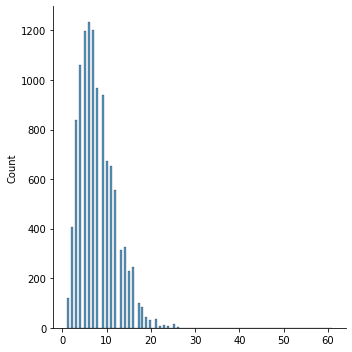

In [47]:
# subject을 길이 분포를 확인한다.
n_len = [len(sub) for sub in subject_idx]

print('평균 =', np.mean(n_len))
print('최소 =', np.min(n_len))
print('최대 =', np.max(n_len))
print('중앙값 =', np.median(n_len))

sns.displot(n_len)
plt.show()

In [56]:
# 문장 길이를 맞추고, 학습 데이터를 생성한다.
x_data = pad_sequences(subject_idx, maxlen=15, padding='post', truncating='post')
y_data = topic

# 학습 데이터와 시험데이터로 분리한다.
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2)
y_train = np.array(y_train).reshape(-1, 1)
y_test = np.array(y_test).reshape(-1, 1)

x_train.shape, y_train.shape, x_test.shape, y_test.shape

((9051, 15), (9051, 1), (2263, 15), (2263, 1))

In [57]:
# LSTM 모델을 생성한다.
EMB_SIZE = 32
VOCAB_SIZE = len(word2idx) + 1
x_input = Input(batch_shape = (None, x_train.shape[1]))
x_embed = Embedding(input_dim=VOCAB_SIZE, output_dim=EMB_SIZE)(x_input)
x_embed = Dropout(0.5)(x_embed)
x_lstm = LSTM(64, dropout=0.5)(x_embed)
y_output = Dense(n_topic, activation = 'softmax')(x_lstm)

model = Model(x_input, y_output)     # 학습, 예측용 모델
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizers.Adam(learning_rate=0.005))
model.summary()


Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 15)]              0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 15, 32)            210528    
_________________________________________________________________
dropout_3 (Dropout)          (None, 15, 32)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                24832     
_________________________________________________________________
dense_3 (Dense)              (None, 20)                1300      
Total params: 236,660
Trainable params: 236,660
Non-trainable params: 0
_________________________________________________________________


In [58]:
# 모델을 학습한다.
hist = model.fit(x_train, y_train, validation_data = (x_test, y_test), batch_size = 512, epochs = 50)

Epoch 1/50
18/18 [==============================] - 5s 135ms/step - loss: 2.9467 - val_loss: 2.7291
Epoch 2/50
18/18 [==============================] - 2s 101ms/step - loss: 2.5692 - val_loss: 2.2788
Epoch 3/50
18/18 [==============================] - 2s 101ms/step - loss: 2.1510 - val_loss: 1.8447
Epoch 4/50
18/18 [==============================] - 2s 101ms/step - loss: 1.7765 - val_loss: 1.5646
Epoch 5/50
18/18 [==============================] - 2s 98ms/step - loss: 1.5494 - val_loss: 1.4124
Epoch 6/50
18/18 [==============================] - 2s 97ms/step - loss: 1.4097 - val_loss: 1.3095
Epoch 7/50
18/18 [==============================] - 2s 98ms/step - loss: 1.2884 - val_loss: 1.2162
Epoch 8/50
18/18 [==============================] - 2s 93ms/step - loss: 1.1819 - val_loss: 1.1841
Epoch 9/50
18/18 [==============================] - 2s 95ms/step - loss: 1.1150 - val_loss: 1.0791
Epoch 10/50
18/18 [==============================] - 2s 95ms/step - loss: 1.0441 - val_loss: 1.0515
Epoch

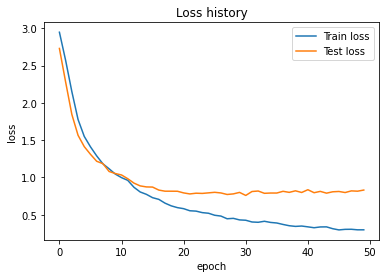

In [59]:
# Loss history를 그린다
plt.plot(hist.history['loss'], label='Train loss')
plt.plot(hist.history['val_loss'], label = 'Test loss')
plt.legend()
plt.title("Loss history")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

In [60]:
# 시험 데이터로 학습 성능을 평가한다
pred = model.predict(x_test)
y_pred = np.argmax(pred, axis=1).reshape(-1, 1)
accuracy = (y_pred == y_test).mean()
print("\nAccuracy = %.2f %s" % (accuracy * 100, '%'))


Accuracy = 82.90 %
